In [1]:
!pip install bfcm

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import sys
sys.path.insert(1, r'..\\src')

import numpy as np
import pandas as pd
import seaborn as sns
import os
                   
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# paths
dataset_path = r'..\\data\\raw'
corr_path = r'..\\data\\processed'
save_path = r"..\\results\\figures\\FCM"
logpath = r"..\\results\\logs\\FCM"

from preprocessing.preprocess_data import preprocess_datasets
from utils import cramers_V, discretize_fcmeans, onehot_aggregator
from bfcm import reasoning, rescaled, hyperbolic, sigmoid
from copy import deepcopy

# for German dataset
colnames_short = ['Checking account', 'Months', 'Credit history', 'Purpose', 'Credit amount', 'Savings account', 'Employment since', 'Installment rate', 'Gender', 'Other debtors', 
                  'Residence since', 'Property', 'Age', 'Other installment', 'Housing', 'Existing credits', 'Job', 'People liable', 'Telephone', 'Foreign worker']

In [3]:
sns.set()
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
paper_rc = {'lines.linewidth': 1, 'lines.markersize': 7} # 
sns.set_context(font_scale=1.4) # , rc=paper_rc, 'paper'

In [3]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

## Case studies

In [4]:
datasets = ['german.data'] # 'german.data', 'synthetic.csv','BROWARD_CLEAN.csv','titanic.csv','adult.data', 'lawschool.csv', 'bank.csv', 'diabetes.csv', 'acsincome.pkl', 'acsemployment.pkl'
df, df_num, metadata, num, binarized_prot = preprocess_datasets(datasets[0], path=dataset_path).preprocess_dataset()

numeric = [False if df[col].dtype == 'object' else True for col in df if col != metadata['target']]
features = [col for col in df.columns if col != metadata['target']]

In [5]:
if len(df) > 100000:
    df = df.sample(10000, random_state=0).reset_index(drop=True)
    df_num = df_num.sample(10000, random_state=0).reset_index(drop=True)
    num = num.sample(10000, random_state=0).reset_index(drop=True)

In [7]:
# create association matrix if it doesn't exist already
for col in np.array(features)[numeric]:
    df[col] = discretize_fcmeans(df, col)
corr_matrix = cramers_V(df, features)
corr_matrix.to_excel(os.path.join(corr_path,metadata['dataset_name']+'_corr_mat.xlsx'))

In [11]:
corr_matrix = pd.read_excel(os.path.join(corr_path,metadata['dataset_name']+'_corr_mat.xlsx'), index_col=0) # , index_col=0
corr_matrix.index = corr_matrix.columns

if metadata['dataset_name'] == 'German':
    corr_matrix.index = colnames_short
    corr_matrix.columns = colnames_short
    metadata['prot1'] = 'Gender'
    metadata['prot2'] = 'Age'
W0 = deepcopy(corr_matrix)

case Gender
phi = 0.2


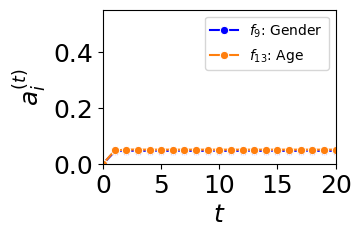

phi = 0.4


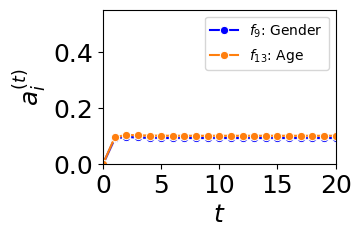

phi = 0.6


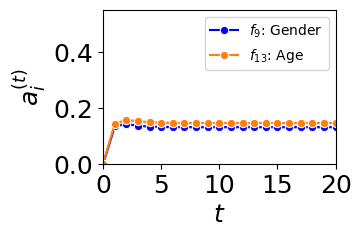

phi = 0.8


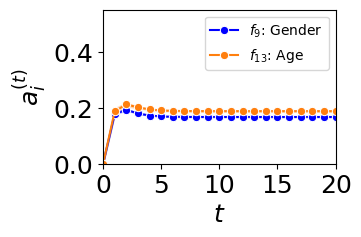

phi = 1


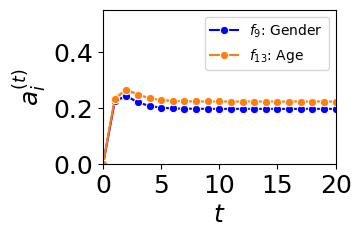

['f14: Housing', 'f6: Employment since', 'f17: People liable']


In [12]:
prot = 'prot1'
prot2 = 'prot2'
case = metadata[prot]
print('case', metadata[prot])
phi_values = [0.2, 0.4, 0.6, 0.8, 1]

n_vars = 3
if corr_matrix.shape[0] < 3:
    n_vars = 2

for phi in phi_values:
    
    df = pd.DataFrame(columns=["var","t","value"])
    
    for i in range(20):

        A = np.zeros((1,len(corr_matrix)))

        # get the location (index) of the most correlated unprotected features with the protected one
        a_unprot = corr_matrix[metadata[prot]].sort_values(ascending=False)
        
        # make sure that other protected features are not selected to activate
        a_unprot = a_unprot.drop(index=[metadata[prot]])
        if metadata[prot2]:
            a_unprot = a_unprot.drop(index=[metadata[prot2]])
        
        # select unprotected features with a correlation of at least 0.1 to the sensitive feature
        unprotected_indices = [corr_matrix.index.get_loc(col) for col, v in zip(a_unprot.index[:n_vars].values, 
                                                                                corr_matrix[metadata[prot]].sort_values(ascending=False).values[:n_vars]) 
                                                                                if v > 0.1]

        # activate the features using several initial values
        for unprot in unprotected_indices:
            A[0][unprot] = np.random.uniform(0.0,1.0)
        
        state = reasoning(W0, A, phi=phi, T=21)           
        
        data_prot1 = state[0,:,corr_matrix.index.get_loc(metadata['prot1'])]
        df1 = pd.DataFrame(columns=["var","t","value"])
        df1["t"] = range(len(data_prot1))
        df1["value"] = data_prot1.tolist()
        df1["var"] = '$f_{'+str(corr_matrix.index.get_loc(metadata['prot1'])+1)+'}$: '+metadata['prot1']
        
        if metadata['prot2']:
            data_prot2 = state[0,:,corr_matrix.index.get_loc(metadata['prot2'])] 
            df2 = pd.DataFrame(columns=["var","t","value"])
            df2["t"] = range(len(data_prot2))
            df2["value"] = data_prot2.tolist()
            df2["var"] = '$f_{'+str(corr_matrix.index.get_loc(metadata['prot2'])+1)+'}$: '+metadata['prot2']
            df = pd.concat([df,df1,df2], ignore_index=True)
        
        df = pd.concat([df,df1], ignore_index=True)

        # happens when there is only one protected feature
        if not metadata['prot2']: # show the other activation values for comparison          
            for unprot in unprotected_indices:
                data_prot1 = state[0,:,unprot]
                df1 = pd.DataFrame(columns=["var","t","value"])
                df1["t"] = range(len(data_prot1))
                df1["value"] = data_prot1.tolist()
                df1["var"] = '$f_{'+str(corr_matrix.index.get_loc(corr_matrix.columns[unprot])+1)+'}$: '+corr_matrix.columns[unprot]
                df = pd.concat([df,df1], ignore_index=True)
    
    plt.figure(figsize=(3,2))
    ax = plt.gca()
    sns.lineplot(data=df, x="t", y="value", hue="var",
                 palette=['b', 'tab:orange', 'tab:green'], ax=ax, marker='o')
    plt.xlabel(r'$t$', fontsize=18)
    plt.ylabel(r'$a_i^{(t)}$', fontsize=18)
    plt.yticks(fontsize=18)
    plt.xticks(fontsize=18)
    plt.ylim(0, 0.55)
    ax.xaxis.get_major_locator().set_params(integer=True)
    plt.legend(loc='best')
    plt.margins(x=0)
    path = os.path.join(save_path, metadata['dataset_name']+"_"+case+ "_A_" + str(phi) + ".jpg") # ,'shap'
    plt.savefig(path, bbox_inches='tight')
    print('phi =', phi)
    plt.show()

print(['f'+str(x)+': '+ y for x,y in zip(unprotected_indices, W0.index[unprotected_indices])])

sigmoid


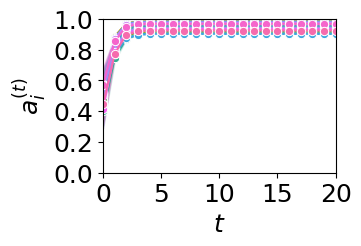

hyperbolic


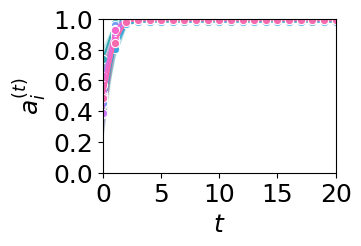

rescaled


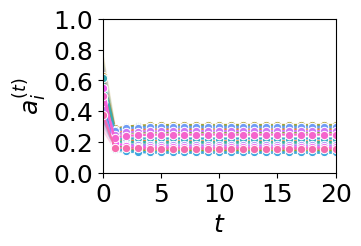

In [13]:
functions = [sigmoid, hyperbolic, rescaled]

np.random.seed(42)
A = np.random.rand(1,20)

for i,func in enumerate(functions):
    
    df = pd.DataFrame(columns=["var","t","value"])
    
    for i in range(20):
        
        A = np.random.rand(1,len(corr_matrix))
        
        state = reasoning(W0, A, phi=1, T=21, function=func)

        for col in range(state.shape[-1]):
            data_col = state[0,:,col] 
            df1 = pd.DataFrame(columns=["var","t","value"])
            df1["t"] = range(len(data_col))
            df1["value"] = data_col.tolist()
            df1["var"] = corr_matrix.columns[col]
            df = pd.concat([df,df1], ignore_index=True)
    
    plt.figure(figsize=(3,2))
    ax = plt.gca()
    sns.lineplot(data=df, x="t", y="value", hue="var", ax=ax, marker='o') # palette="BrBG"
    plt.yticks(fontsize=18)
    plt.xticks(fontsize=18)
    plt.xlabel(r'$t$', fontsize=18)
    plt.ylabel(r'$a_i^{(t)}$', fontsize=18)
    plt.ylim(0, 1.0)
    ax.xaxis.get_major_locator().set_params(integer=True)
    plt.legend().remove()
    plt.margins(x=0)
    f = str(func).split(" ")[1]
    path = os.path.join(save_path, metadata['dataset_name']+"_"+ f + "_A_" + str(1.0) + ".jpg") # + "_Wpair_" and ,'shap'
    plt.savefig(path, bbox_inches='tight')
    print(f)
    plt.show()

## Individual bias with SHAP feature importance

In [14]:
import shap
import pickle
shap.initjs()
from copy import deepcopy
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, accuracy_score

In [15]:
if metadata['dataset_name'] == 'German':
    metadata['prot1'] = 'Gender'
    metadata['prot2'] = 'Age'

In [16]:
X = deepcopy(df_num)
y = X.pop(metadata['target'])

X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=0) 
# random_state should be 7 for german credit, 0 for titanic, 3 for adult
model = RandomForestClassifier(random_state=0, criterion='log_loss').fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print(accuracy_score(Y_test,Y_pred), balanced_accuracy_score(Y_test,Y_pred), Y_test.value_counts(normalize=True))

0.775 0.6726190476190477 Creditworthiness
1.0    0.7
0.0    0.3
Name: proportion, dtype: float64


In [ ]:
explainer = shap.Explainer(model.predict, X_test, seed=0)
shap_values1 = explainer(X_test)

original_columns = list(df.columns)
original_columns.remove(metadata['target'])

nominal = df[original_columns].loc[:,np.invert(np.array(numeric))].columns
agg_shap = onehot_aggregator(shap_values1.values, nominal, X.columns, original_columns, metadata)

shap_values1.feature_names = original_columns
shap_values1.values = agg_shap.values

import pickle
shap_results = shap_values1
with open(os.path.join(filepath, 'temp','shap', metadata['dataset_name']+"_"+'SHAP.pickle'), 'wb') as handle:
    pickle.dump(shap_results, handle)